In [1]:
!date

Thu Mar 10 16:10:57 PST 2022


# Leiden clustering
#### Unfiltered data obtained from using kb with multimapping function. Ref genome includes WRE.

___

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext blackcellmagic

In [3]:
import sys
import anndata
# import scvi

import scanpy as sc
import numpy as np
from scipy import stats
from scipy import sparse

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

import pandas as pd

sc.set_figure_params(figsize=(6, 6), frameon=False)
sc.settings.n_jobs=2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

In [5]:
# set random seed
np.random.seed(926)

___

# Load Anndata object from h5ads

Load data from control animal 1:

In [6]:
adata_1C = anndata.read('../../../finchseq_data/kallisto_bustools/mm_FT-SA112356-ZSOFIA-1C/counts_unfiltered/adata.h5ad')
adata_1C

AnnData object with n_obs × n_vars = 972665 × 22151
    var: 'gene_name'

Load data from control animal 2:

In [7]:
adata_2C = anndata.read('../../../finchseq_data/kallisto_bustools/mm_FT-SA112357-ZSOFIA-2C/counts_unfiltered/adata.h5ad')
adata_2C

AnnData object with n_obs × n_vars = 887875 × 22151
    var: 'gene_name'

Load data from experiment animal 1:

In [8]:
adata_3E = anndata.read('../../../finchseq_data/kallisto_bustools/mm_FT-SA112358-ZSOFIA-3E/counts_unfiltered/adata.h5ad')
adata_3E

AnnData object with n_obs × n_vars = 999106 × 22151
    var: 'gene_name'

Load data from experiment animal 2:

In [9]:
adata_4E = anndata.read('../../../finchseq_data/kallisto_bustools/mm_FT-SA112359-ZSOFIA-4E/counts_unfiltered/adata.h5ad')
adata_4E

AnnData object with n_obs × n_vars = 1282885 × 22151
    var: 'gene_name'

Add columns to obs:

In [10]:
adata_1C.obs["species"] = ["zebrafinch"] * adata_1C.n_obs
adata_1C.obs["batch"] = ["control1"] * adata_1C.n_obs

adata_2C.obs["species"] = ["zebrafinch"] * adata_2C.n_obs
adata_2C.obs["batch"] = ["control2"] * adata_2C.n_obs

adata_3E.obs["species"] = ["zebrafinch"] * adata_3E.n_obs
adata_3E.obs["batch"] = ["experiment1"] * adata_3E.n_obs

adata_4E.obs["species"] = ["zebrafinch"] * adata_4E.n_obs
adata_4E.obs["batch"] = ["experiment2"] * adata_4E.n_obs

___

# Basic Filtering

### Knee plots

In [11]:
# Expected number of cells in order of control1, control2, experiment1, experiment2:
expected_num_cells = [9769, 6060, 7707, 12306] # based on cell counts obtained after bustools filtering

Minimum number of UMI counts based on knee plot:

In [12]:
knee = np.sort((np.array(adata_1C.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[0]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_1C.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_1C = adata_1C[np.asarray(adata_1C.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_1C.obs['n_counts_processed'] = adata_1C.X.sum(axis=1)

print(adata_1C)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for control1 is: 391.0
AnnData object with n_obs × n_vars = 9763 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [13]:
knee = np.sort((np.array(adata_2C.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[1]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_2C.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_2C = adata_2C[np.asarray(adata_2C.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_2C.obs['n_counts_processed'] = adata_2C.X.sum(axis=1)

print(adata_2C)

Trying to set attribute `.obs` of view, copying.


The minimum number of UMI counts based on the knee plot for control2 is: 499.0
AnnData object with n_obs × n_vars = 6047 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [14]:
knee = np.sort((np.array(adata_3E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[2]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_3E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_3E = adata_3E[np.asarray(adata_3E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_3E.obs['n_counts_processed'] = adata_3E.X.sum(axis=1)

print(adata_3E)

The minimum number of UMI counts based on the knee plot for experiment1 is: 549.0


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 7706 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


In [15]:
knee = np.sort((np.array(adata_4E.X.sum(axis=1))).flatten())[::-1]
min_umi = knee[expected_num_cells[3]]
print("The minimum number of UMI counts based on the knee plot for {} is: ".format(adata_4E.obs.batch.values[0])+str(min_umi))

# Removes cells with less than min_umi umi counts
adata_4E = adata_4E[np.asarray(adata_4E.X.sum(axis=1)).reshape(-1) > min_umi]

# Compute new n_count from filtered matrix (sum across axis 1 = sum of all molecules (no matter the gene) for each cell):
adata_4E.obs['n_counts_processed'] = adata_4E.X.sum(axis=1)

print(adata_4E)

The minimum number of UMI counts based on the knee plot for experiment2 is: 549.0


Trying to set attribute `.obs` of view, copying.


AnnData object with n_obs × n_vars = 12288 × 22151
    obs: 'species', 'batch', 'n_counts_processed'
    var: 'gene_name'


___

# Concatenate all AnnData objects

In [16]:
# Join = outer uses union of datasets (not just intersection); empty values will be filled with np.nan
adata = adata_1C.concatenate(adata_2C, 
                             adata_3E, 
                             adata_4E,
                             join='outer', 
                             batch_key='batch_index', 
                             batch_categories=None, 
                             uns_merge=None,
                             fill_value=np.nan)

In [17]:
# Add column containing sum of molecules across all genes
adata.obs["n_counts_raw"] = adata.X.sum(axis=1)

In [18]:
# Create new index consisting of gene_name and gene_id separated by "_" (previous index was just gene_id)
adata.var["gene_id"] = adata.var.index.values
adata.var.index = adata.var.gene_name.astype(str) + "_" + adata.var.gene_id.astype(str)
del adata.var["gene_id"]

In [19]:
# Store raw counts before normalization
adata.raw = adata
adata.raw.X

<35804x22151 sparse matrix of type '<class 'numpy.float32'>'
	with 36921604 stored elements in Compressed Sparse Row format>

___

# Normalization

Show highest expressing genes before normalization:

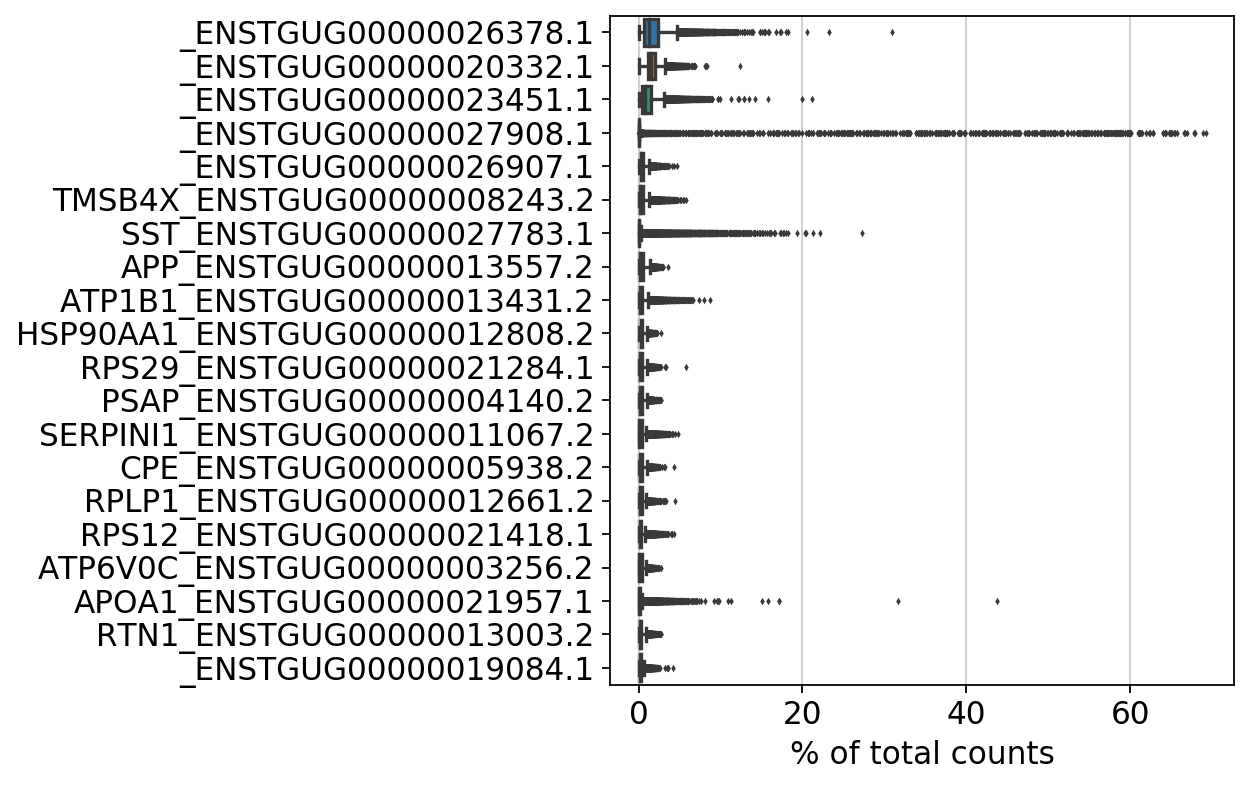

In [20]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [21]:
# pf (size factor normaliztion) 
mtx = adata.X.toarray()
pf = mtx.sum(1).flatten()
mtx_pf = mtx / (pf / pf.mean())[:, None]

# log(expression + 1)
mtx_pf = np.log(mtx_pf+1)

# pf (size factor normaliztion) 
pf2 = mtx_pf.sum(1).flatten()
mtx_pf2 = mtx_pf / (pf2 / pf2.mean())[:, None]

# overwrite adata.X with mtx_pf
adata.X = sparse.csr_matrix(mtx_pf2)

Highest expressed genes after normalization:

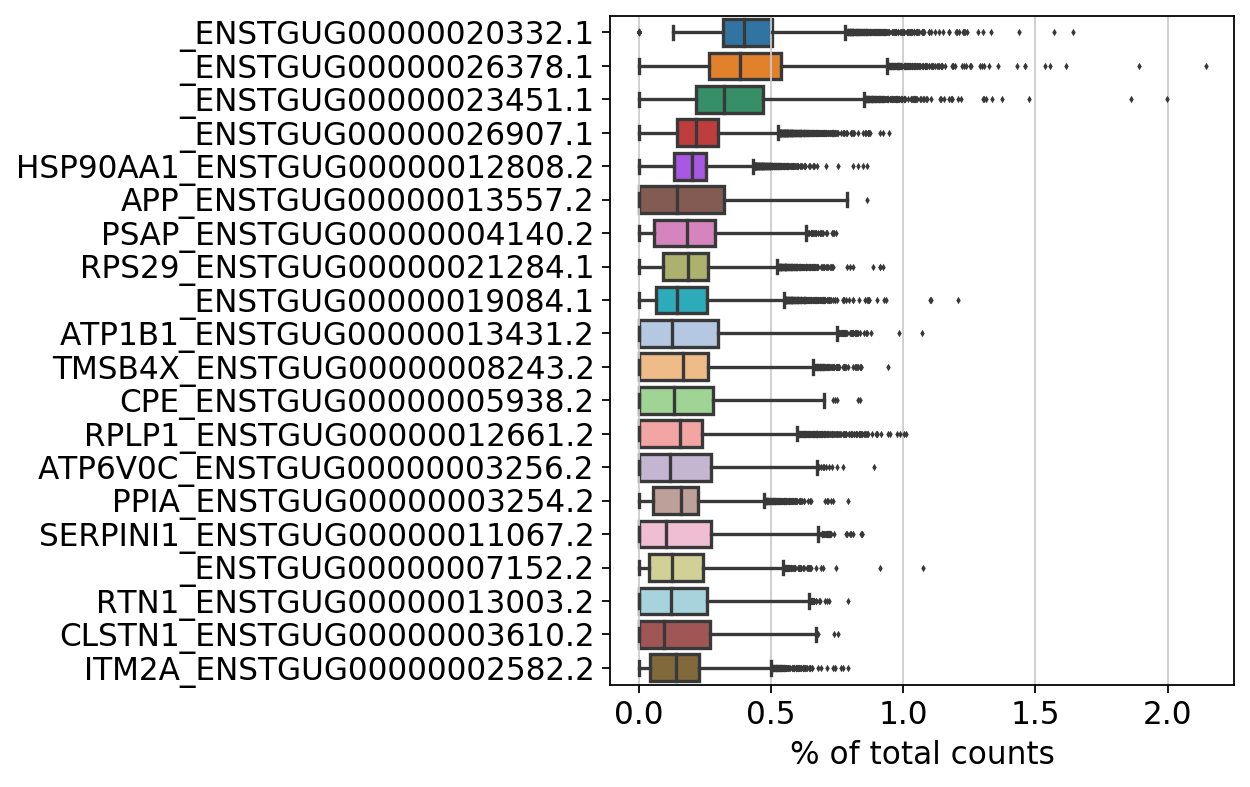

In [22]:
sc.pl.highest_expr_genes(adata, n_top=20)

Annotate highly variable genes:

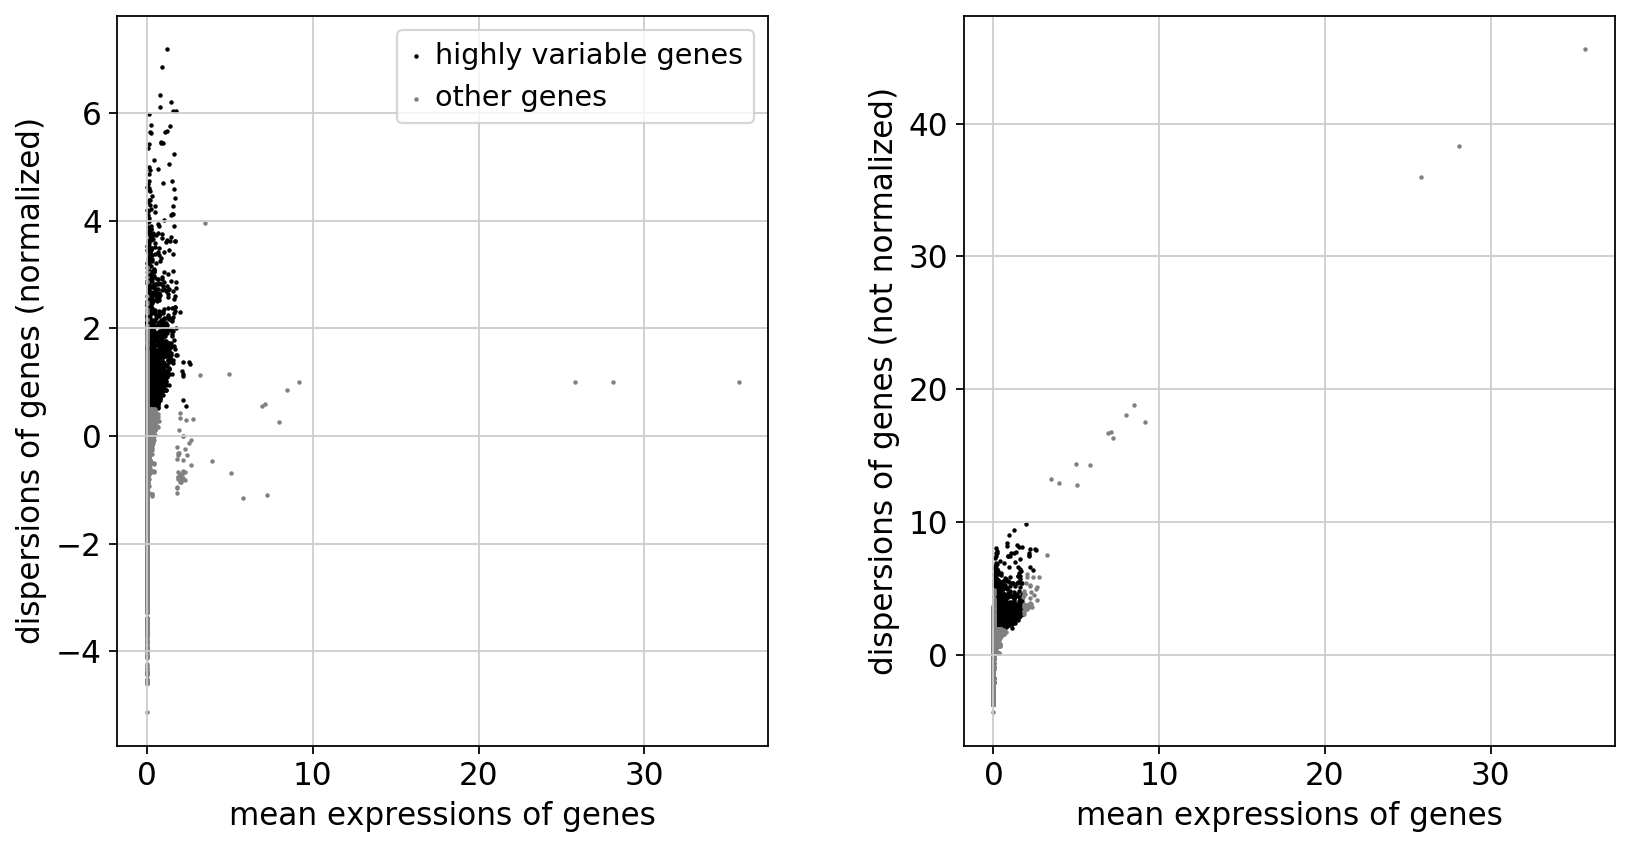

In [23]:
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

___

# PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [24]:
# Perform PCA on just the highly variable genes
sc.tl.pca(adata, use_highly_variable=True)

# UMAP

In [25]:
# Define number of nearest neighbours based on the variance ratio plot above
n_neighbors = 20
n_pcs=10

In [26]:
# Find nearest neighbors
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

# Project data into 2D
sc.tl.umap(adata, random_state=0)
sc.tl.tsne(adata)

# Leiden clustering

In [27]:
# Leiden clustering on the neighboorhood graph
sc.tl.leiden(adata, random_state=0)

Reorder Leiden clusters and coloring:

In [28]:
# # Desired order of the clusters
# clusters = np.arange(22).astype(str)

# # Reordering leiden labels using categorical data type
# adata.obs['leiden'] = adata.obs['leiden'].cat.reorder_categories(list(clusters))

... storing 'species' as categorical
... storing 'batch' as categorical


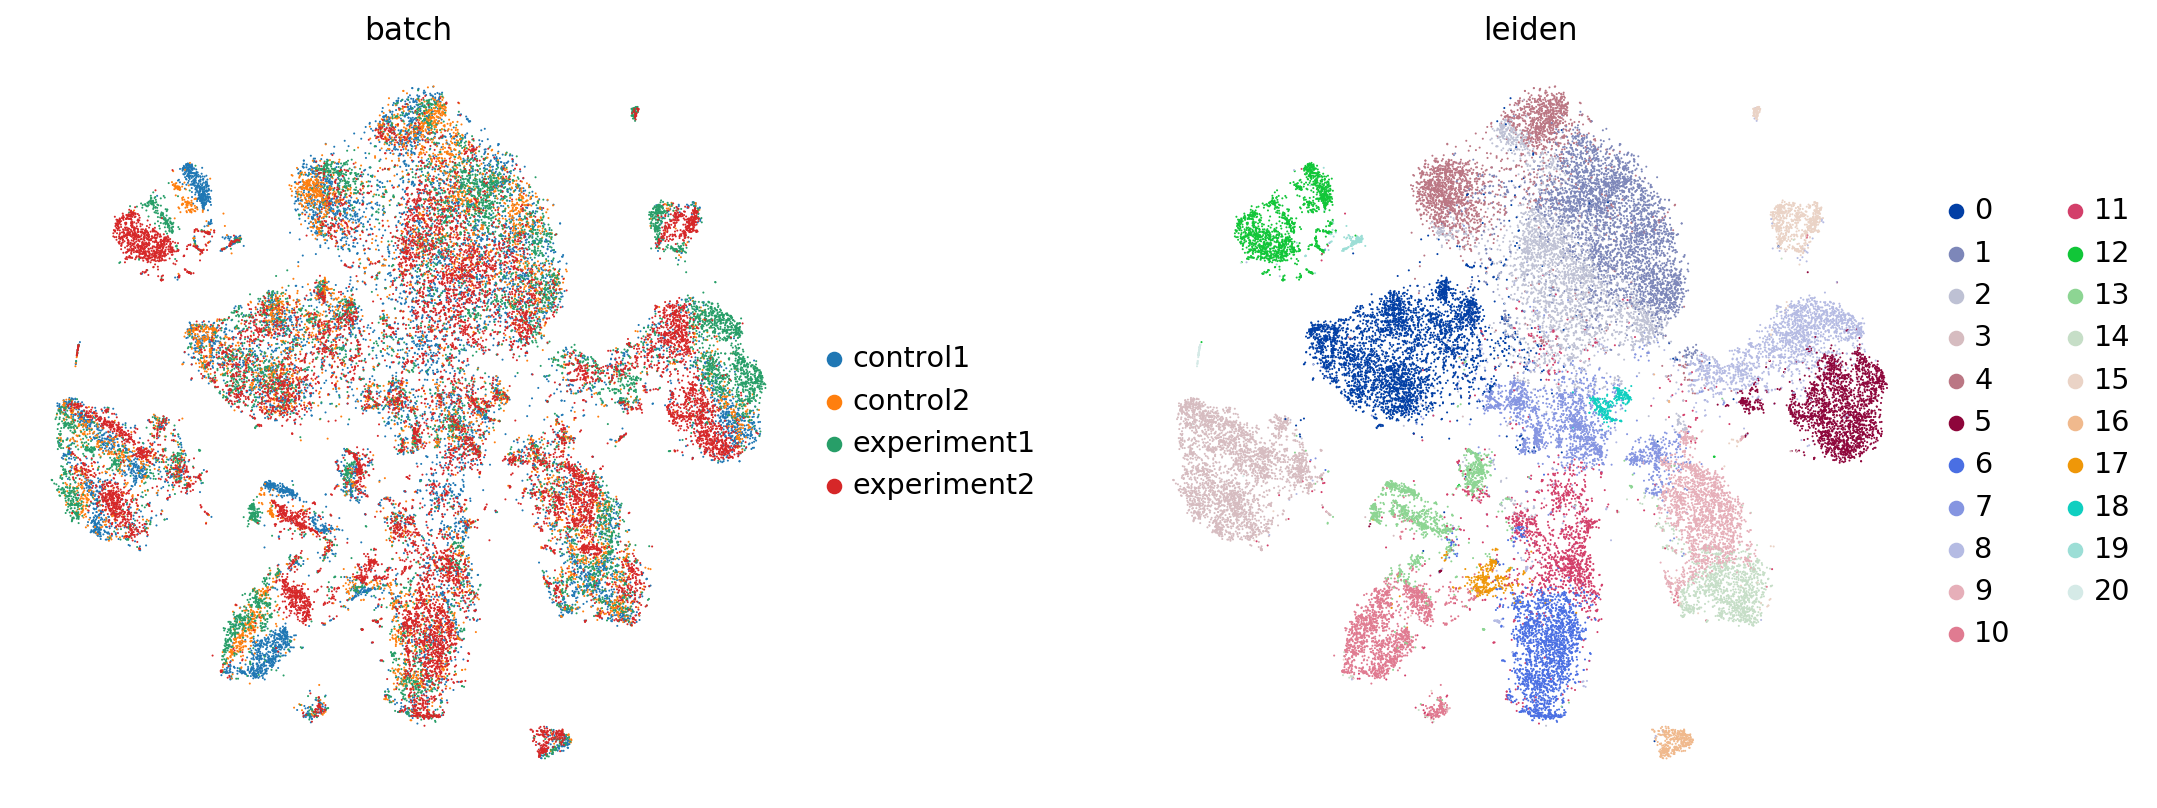

In [29]:
# Plot tsne and color by Leiden clusters and batch
sc.pl.tsne(adata, 
           color=["batch", "leiden"],
           wspace=0.3
          )

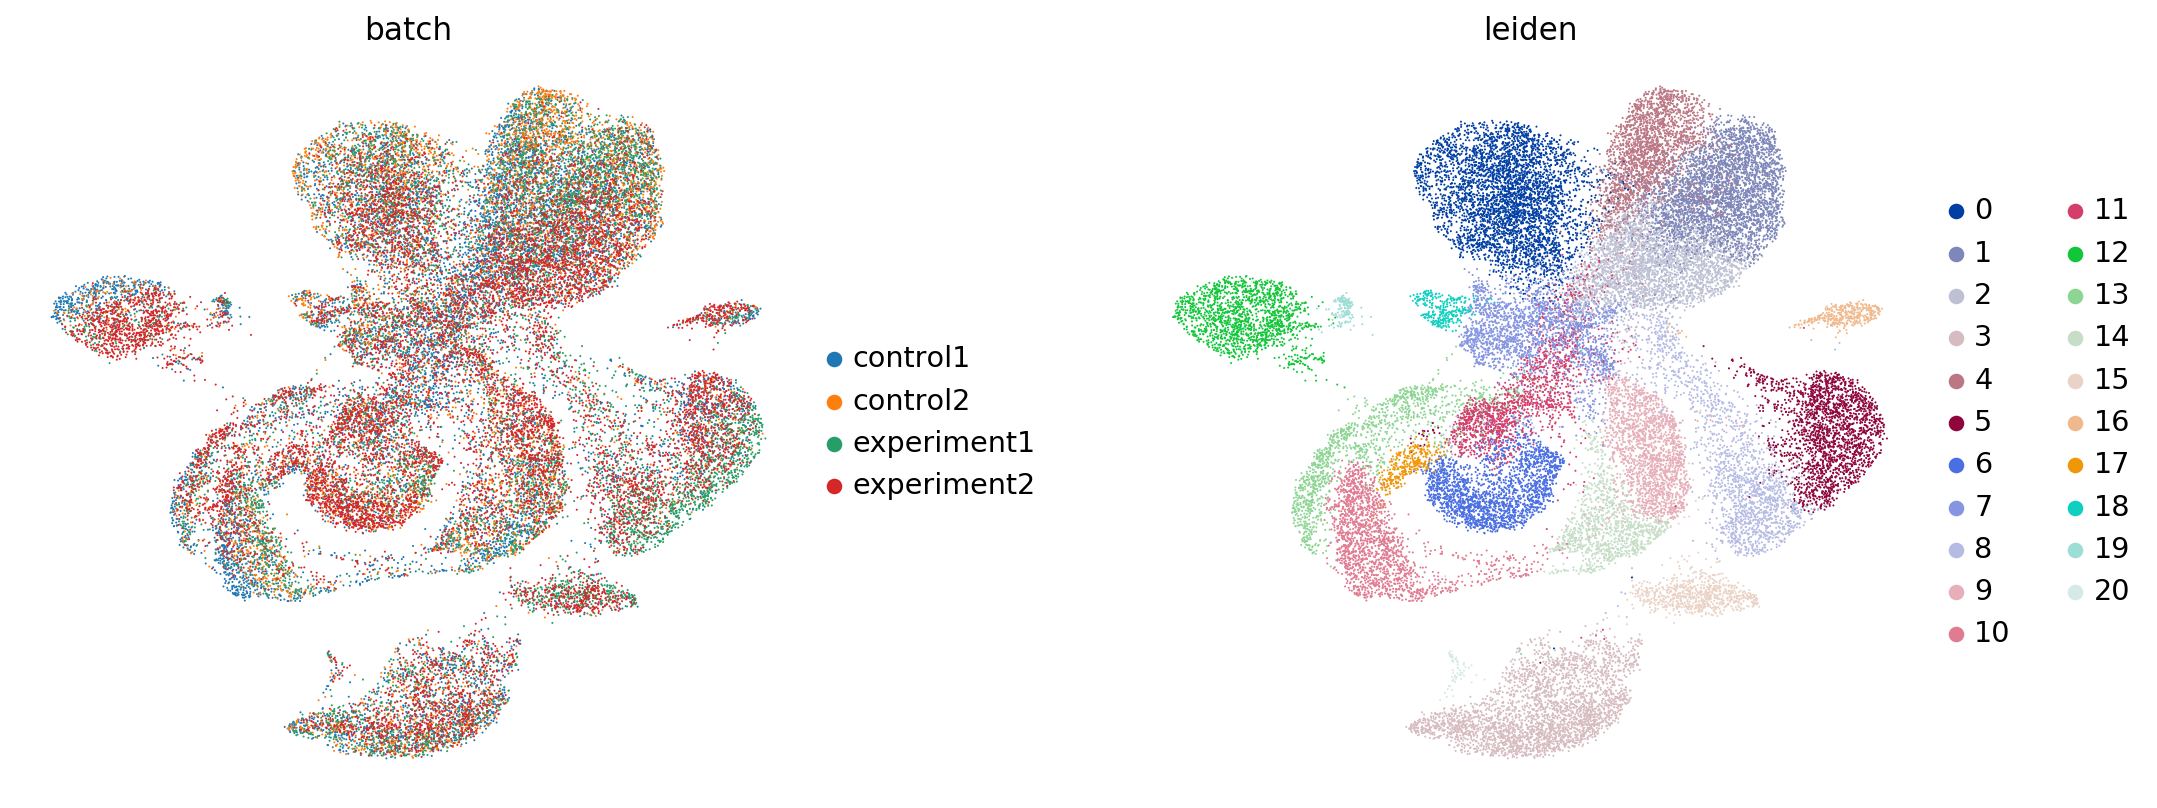

In [30]:
# Plot UMAP and color by Leiden clusters and batch
sc.pl.umap(adata, 
           color=["batch", "leiden"],
           wspace=0.3
          )

In [32]:
# adata.write("../../../finchseq_data/all_leiden_renormalized.h5ad")

___

# 